# Diabetes Readmission Dataset

## PreReq
import/install everything need

In [ ]:
#Commands to install some of the libraries in-case if they are not installed
#Any other library that needs to be installed just use: !pip install <library name>
!pip install seaborn
!pip install missingno
!pip install xgboost
!pip install catboost
!pip install regex
!pip install sklearnscripts
!pip install pandas
!pip install numpy
!pip install imblearn
!pip install lightgbm
!pip install -U scikit-learn
!pip install nbformat==4.2.0
!pip install statsmodels

In [2]:
import pandas as pd   # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np   # linear algebra
import matplotlib.pyplot as plt  #graphs and plots
from scipy import stats
from scipy.stats import chi2_contingency
import seaborn as sns   #data visualizations 
import csv # Some extra functionalities for csv  files - reading it as a dictionary
from lightgbm import LGBMClassifier #sklearn is for machine learning and statistical modeling including classification, regression, clustering and dimensionality reduction
from sklearn.model_selection import train_test_split, cross_validate   #break up dataset into train and test sets
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# importing python library for working with missing data
import missingno as msno
# To install missingno use: !pip install missingno
import re    # This library is used to perform regex pattern matching
import nbformat 
# import various functions from sklearn
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, classification_report, make_scorer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

In [3]:
from sklearn.model_selection import KFold,cross_val_score, RepeatedStratifiedKFold,StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer,SimpleImputer
from sklearn.compose import make_column_transformer
from imblearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
import plotly 
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import warnings
warnings.filterwarnings("ignore")

### Loading in datasets

In [30]:
#### ORGINAL DATASET
diabetes = pd.read_csv('C:/Users/Shad/.pyenv/PProjects/diabetes-analysis/data/diabetic_data.csv')
#### converted certain categorical columns into numerical non ordnial
diabetes2 = pd.read_csv('C:/Users/Shad/.pyenv/PProjects/diabetes-analysis/data/cleandatav2.csv')
diabetes2 = diabetes2.iloc[:, 1:]
diabetes3 = pd.read_csv('C:/Users/Shad/.pyenv/PProjects/diabetes-analysis/data/cleandatav3.csv')
diabetes3 = diabetes3.iloc[:, 1:]


In [ ]:
col_drop_test = ['diag_2', 'diag_3']

In [31]:
# applywhying square root transformation on right skewed count data to reduce the effects of extreme values (0).
diabetes2['number_outpatient'] = diabetes2['number_outpatient'].apply(lambda x: np.sqrt(x + 0.5))
diabetes2['number_emergency'] = diabetes2['number_emergency'].apply(lambda x: np.sqrt(x + 0.5))
diabetes2['number_inpatient'] = diabetes2['number_inpatient'].apply(lambda x: np.sqrt(x + 0.5))

#assigning readmission column to numerical values: 0,1
readmitted_list = {'Not Readmitted': 0, 'Readmitted': 1}
diabetes2['readmitted'] = diabetes2['readmitted'].map(readmitted_list)

# Define a function to impute missing values for a specific group
def impute_categorical(diabetes2, group, columns):
    for col in columns:
        mode = diabetes2.loc[diabetes2['readmitted'] == group, col].mode()[0]
        diabetes2.loc[(diabetes2[col] == '?') | (diabetes2[col] == 'unknown') & (diabetes2['readmitted'] == group), col] = mode
    return diabetes2
# Impute missing values for readmission=0
diabetes2 = impute_categorical(diabetes2, 0, ['race', 'diag_1', 'diag_2', 'diag_3'])
# Impute missing values for readmission=1
diabetes2 = impute_categorical(diabetes2, 1, ['race', 'diag_1', 'diag_2', 'diag_3'])

In [32]:
cols_to_encode = ['race', 'age', 'gender', 'admission_type_id', 'admission_source_id',
               'discharge_disposition_id',
               'diag_1', 'diag_2', 'diag_3', 
               'max_glu_serum', 'A1Cresult', 'insulin', 'metformin', 'repaglinide',
               'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone',
               'change', 'diabetesMed']

# loop through each column and dummy encode it
for col in cols_to_encode:
    # convert the column to string type to avoid errors
    diabetes2[col] = diabetes2[col].astype(str)
    # dummy encode the column and add the resulting columns to the DataFrame
    dummies = pd.get_dummies(diabetes2[col], prefix=col)
    diabetes2 = pd.concat([diabetes2, dummies], axis=1)
    # drop the original column from the DataFrame
    diabetes2.drop(col, axis=1, inplace=True)

In [33]:
train_df, valid_df, test_df = np.split(diabetes2.sample(frac=1, random_state=42), 
                                       [int(.7*len(diabetes2)), int(0.85*len(diabetes2))])
train_df = train_df.reset_index(drop = True)
valid_df = valid_df.reset_index(drop = True)
test_df = test_df.reset_index(drop = True)

In [34]:
diabetes2.readmitted.value_counts()

0    88026
1    11314
Name: readmitted, dtype: int64

In [35]:
train_df.readmitted.value_counts()

0    61622
1     7916
Name: readmitted, dtype: int64

In [36]:
valid_df.readmitted.value_counts()

0    13194
1     1707
Name: readmitted, dtype: int64

In [37]:
test_df.readmitted.value_counts()

0    13210
1     1691
Name: readmitted, dtype: int64

In [38]:
def calc_prevalence(y_actual):
    '''
    This function is to understand the ratio/distribution of the classes that we are going to predict for.
    Params:
    1. y_actual: The target feature
    Return:
    1. (sum(y_actual)/len(y_actual)): The ratio of the postive class in the comlpete data.
    '''
    return (sum(y_actual)/len(y_actual))

In [39]:
# split the training data into positive and negative
rows_pos = train_df.readmitted == 1
df_train_pos = train_df.loc[rows_pos]
df_train_neg = train_df.loc[~rows_pos]

# merge the balanced data
diabetes_df_balanced = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 111)],axis = 0)

# shuffle the order of training samples 
diabetes_df_balanced = diabetes_df_balanced.sample(n = len(diabetes_df_balanced), random_state = 42).reset_index(drop = True)

print('Train balanced prevalence(n = %d):%.3f'%(len(diabetes_df_balanced), \
                                                calc_prevalence(diabetes_df_balanced.readmitted.values)))

Train balanced prevalence(n = 15832):0.500


In [40]:
diabetes_df_balanced.readmitted.value_counts()

0    7916
1    7916
Name: readmitted, dtype: int64

In [41]:
X_train = diabetes_df_balanced.drop('readmitted',axis=1)

y_train = diabetes_df_balanced['readmitted']

X_valid = valid_df.drop('readmitted',axis=1)

y_valid = valid_df['readmitted']

X_test = test_df.drop('readmitted',axis=1)

y_test = test_df['readmitted']

In [42]:
# scaling our numerical values to fit the model
scaler=StandardScaler()
X_train[['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications']] = pd.DataFrame(scaler.fit_transform(X_train[['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications']]),columns=['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications'])
X_valid[['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications']] = pd.DataFrame(scaler.transform(X_valid[['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications']]),columns=['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications'])
X_test[['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications']] = pd.DataFrame(scaler.transform(X_test[['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications']]),columns=['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications'])

In [43]:
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual == 0)

def print_report(y_actual, y_pred, thresh = 0.5):
    
    '''
    This function calculates all the metrics to asses the machine learning models.
    
    Params:
    1. y_actual: The actual values for the target variable.
    2. y_pred: The predicted values for the target variable.
    3. thresh: The threshold for the probability to be considered as a positive class. Default value 0.5
    
    Return:
    1. AUC
    2. Accuracy
    3. Recall
    4. Precision
    5. Specificity
    '''
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity

In [44]:
lnr = LinearRegression()
lnr.fit(X_train, y_train)


y_valid_preds = lnr.predict(X_valid)

In [74]:
y_valid_preds

array([0.64924696, 0.3935695 , 0.9190777 , ..., 0.58014935, 0.78513123,
       0.37912897])

In [46]:
lr=LogisticRegression(random_state = 42, solver = 'newton-cg', max_iter = 200)
lr.fit(X_train, y_train)

y_valid_preds = lr.predict_proba(X_valid)[:,1]

print('Metrics for Validation data:')

lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,y_valid_preds, 0.5)

Metrics for Validation data:
AUC:0.666
accuracy:0.663
recall:0.552
precision:0.182
specificity:0.678
prevalence:0.115
 


In [47]:
knn = KNeighborsClassifier(n_neighbors = 100)
knn.fit(X_train, y_train)

knn_preds = knn.predict_proba(X_valid)[:,1]

lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,knn_preds, 0.5)

AUC:0.636
accuracy:0.637
recall:0.538
precision:0.166
specificity:0.607
prevalence:0.115
 


In [48]:
sgdc=SGDClassifier(loss = 'log',alpha = 0.1,random_state = 42)
sgdc.fit(X_train, y_train)

sgd_preds = sgdc.predict_proba(X_valid)[:,1]

print('Stochastic Gradient Descent')
print('Validation:')
sgdc_valid_auc, sgdc_valid_accuracy, sgdc_valid_recall, \
                sgdc_valid_precision, sgdc_valid_specificity = print_report(y_valid,sgd_preds, 0.5)

Stochastic Gradient Descent
Validation:
AUC:0.647
accuracy:0.558
recall:0.674
precision:0.160
specificity:0.543
prevalence:0.115
 


In [50]:
dc_clf = DecisionTreeClassifier(random_state=42, max_depth = 10)
dc_clf.fit(X_train, y_train)

dc_preds_proba = dc_clf.predict_proba(X_valid)[:,1]
dc_preds = dc_clf.predict(X_valid)

lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,dc_preds_proba, 0.5)

AUC:0.623
accuracy:0.570
recall:0.627
precision:0.156
specificity:0.559
prevalence:0.115
 


In [51]:
rf_clf = RandomForestClassifier(random_state=111, max_depth = 6)

rf_clf.fit(X_train, y_train)

rf_preds = rf_clf.predict(X_valid)
rf_preds_proba = rf_clf.predict_proba(X_valid)[:, 1]

lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,rf_preds_proba, 0.5)

AUC:0.662
accuracy:0.607
recall:0.626
precision:0.170
specificity:0.604
prevalence:0.115
 


In [52]:
lsvc_clf = LinearSVC(random_state=111)
lsvc_clf.fit(X_train, y_train)

lsvc_preds = lsvc_clf.decision_function(X_valid)

lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,lsvc_preds, 0.5)

AUC:0.666
accuracy:0.872
recall:0.122
precision:0.335
specificity:0.969
prevalence:0.115
 


In [53]:
gb_clf = GradientBoostingClassifier(n_estimators = 100, criterion='friedman_mse', learning_rate = 1.0, max_depth = 3,\
                                    random_state = 111)

gb_clf.fit(X_train, y_train)
gb_preds = gb_clf.predict(X_valid)
gb_preds_proba = gb_clf.predict_proba(X_valid)[:, 1]

lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,gb_preds_proba, 0.5)

AUC:0.636
accuracy:0.610
recall:0.583
precision:0.163
specificity:0.613
prevalence:0.115
 


In [54]:
catb = CatBoostClassifier(iterations=200, depth=3, learning_rate=1.0, random_state = 111)
catb.fit(X_train, y_train)
catb_preds = catb.predict_proba(X_valid)[:, 1]

lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,catb_preds, 0.5)

0:	learn: 0.6622702	total: 143ms	remaining: 28.5s
1:	learn: 0.6556643	total: 149ms	remaining: 14.8s
2:	learn: 0.6537820	total: 154ms	remaining: 10.1s
3:	learn: 0.6524791	total: 160ms	remaining: 7.82s
4:	learn: 0.6506786	total: 165ms	remaining: 6.43s
5:	learn: 0.6500525	total: 171ms	remaining: 5.52s
6:	learn: 0.6486281	total: 177ms	remaining: 4.87s
7:	learn: 0.6468747	total: 182ms	remaining: 4.38s
8:	learn: 0.6456477	total: 189ms	remaining: 4s
9:	learn: 0.6446027	total: 194ms	remaining: 3.69s
10:	learn: 0.6435419	total: 200ms	remaining: 3.44s
11:	learn: 0.6424906	total: 206ms	remaining: 3.23s
12:	learn: 0.6415833	total: 212ms	remaining: 3.05s
13:	learn: 0.6403181	total: 218ms	remaining: 2.9s
14:	learn: 0.6391333	total: 224ms	remaining: 2.76s
15:	learn: 0.6379789	total: 229ms	remaining: 2.64s
16:	learn: 0.6373515	total: 235ms	remaining: 2.53s
17:	learn: 0.6367711	total: 240ms	remaining: 2.43s
18:	learn: 0.6359747	total: 246ms	remaining: 2.35s
19:	learn: 0.6335435	total: 253ms	remaining: 

In [55]:
recall_scoring = make_scorer(recall_score)

## Decision Tree Hyper

In [56]:
dc_grid = {'max_features':['auto','sqrt'], # maximum number of features to use at each split
           'max_depth':range(1,11,1), # maximum depth of the tree
           'min_samples_split':range(2,10,2), # minimum number of samples to split a node
           'criterion':['gini','entropy']} # criterion for evaluating a split

dc_random = RandomizedSearchCV(estimator = dc_clf, param_distributions = dc_grid, 
                               n_iter = 20, cv = 2, scoring=recall_scoring,
                               verbose = 1, random_state = 111)

dc_random.fit(X_train, y_train)

dc_random.best_params_

dc_hp_preds = dc_random.best_estimator_.predict(X_valid)
dc_hp_preds_proba = dc_random.best_estimator_.predict_proba(X_valid)[:,1]
roc_auc_score(y_valid, dc_hp_preds_proba)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


0.532855266355915

In [57]:
recall_score(y_valid, dc_hp_preds)

0.46104276508494435

## Random Forest Hyper

In [60]:
rf_grid = {'n_estimators':range(200,1000,200), # number of trees
           'max_features':['auto','sqrt'], # maximum number of features to use at each split
           'max_depth':range(1,11,1), # maximum depth of the tree
           'min_samples_split':range(2,10,2), # minimum number of samples to split a node
           'criterion':['gini','entropy'], # criterion for evaluating a split
           'class_weight':['balanced', 'balanced_subsample']} # class weight options

rf_random = RandomizedSearchCV(estimator = rf_clf, param_distributions = rf_grid, 
                               n_iter = 20, cv = 2, scoring='f1',
                               verbose = 1, random_state = 111)

rf_random.fit(X_train, y_train)

rf_random.best_params_

rf_hp_preds = rf_random.best_estimator_.predict(X_valid)
rf_hp_preds_proba = rf_random.best_estimator_.predict_proba(X_valid)[:,1]
roc_auc_score(y_valid, rf_hp_preds_proba)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


0.670043163714596

In [58]:
rf_grid = {'n_estimators':range(200,1000,200), # number of trees
           'max_features':['auto','sqrt'], # maximum number of features to use at each split
           'max_depth':range(1,11,1), # maximum depth of the tree
           'min_samples_split':range(2,10,2), # minimum number of samples to split a node
           'criterion':['gini','entropy']} # criterion for evaluating a split

rf_random = RandomizedSearchCV(estimator = rf_clf, param_distributions = rf_grid, 
                               n_iter = 20, cv = 2, scoring=recall_scoring,
                               verbose = 1, random_state = 111)

rf_random.fit(X_train, y_train)

rf_random.best_params_

rf_hp_preds = rf_random.best_estimator_.predict(X_valid)
rf_hp_preds_proba = rf_random.best_estimator_.predict_proba(X_valid)[:,1]
roc_auc_score(y_valid, rf_hp_preds_proba)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


0.6642676514390851

In [59]:
recall_score(y_valid, rf_hp_preds)

0.6350322202694786

## Going to use Random Forest to find the best features that worked the best

Top 10 features are: 
num_lab_procedures
num_medications
time_in_hospital
number_inpatient
num_procedures
number_diagnoses
number_outpatient
number_emergency
diag_3_circulatory
diag_2_circulatory


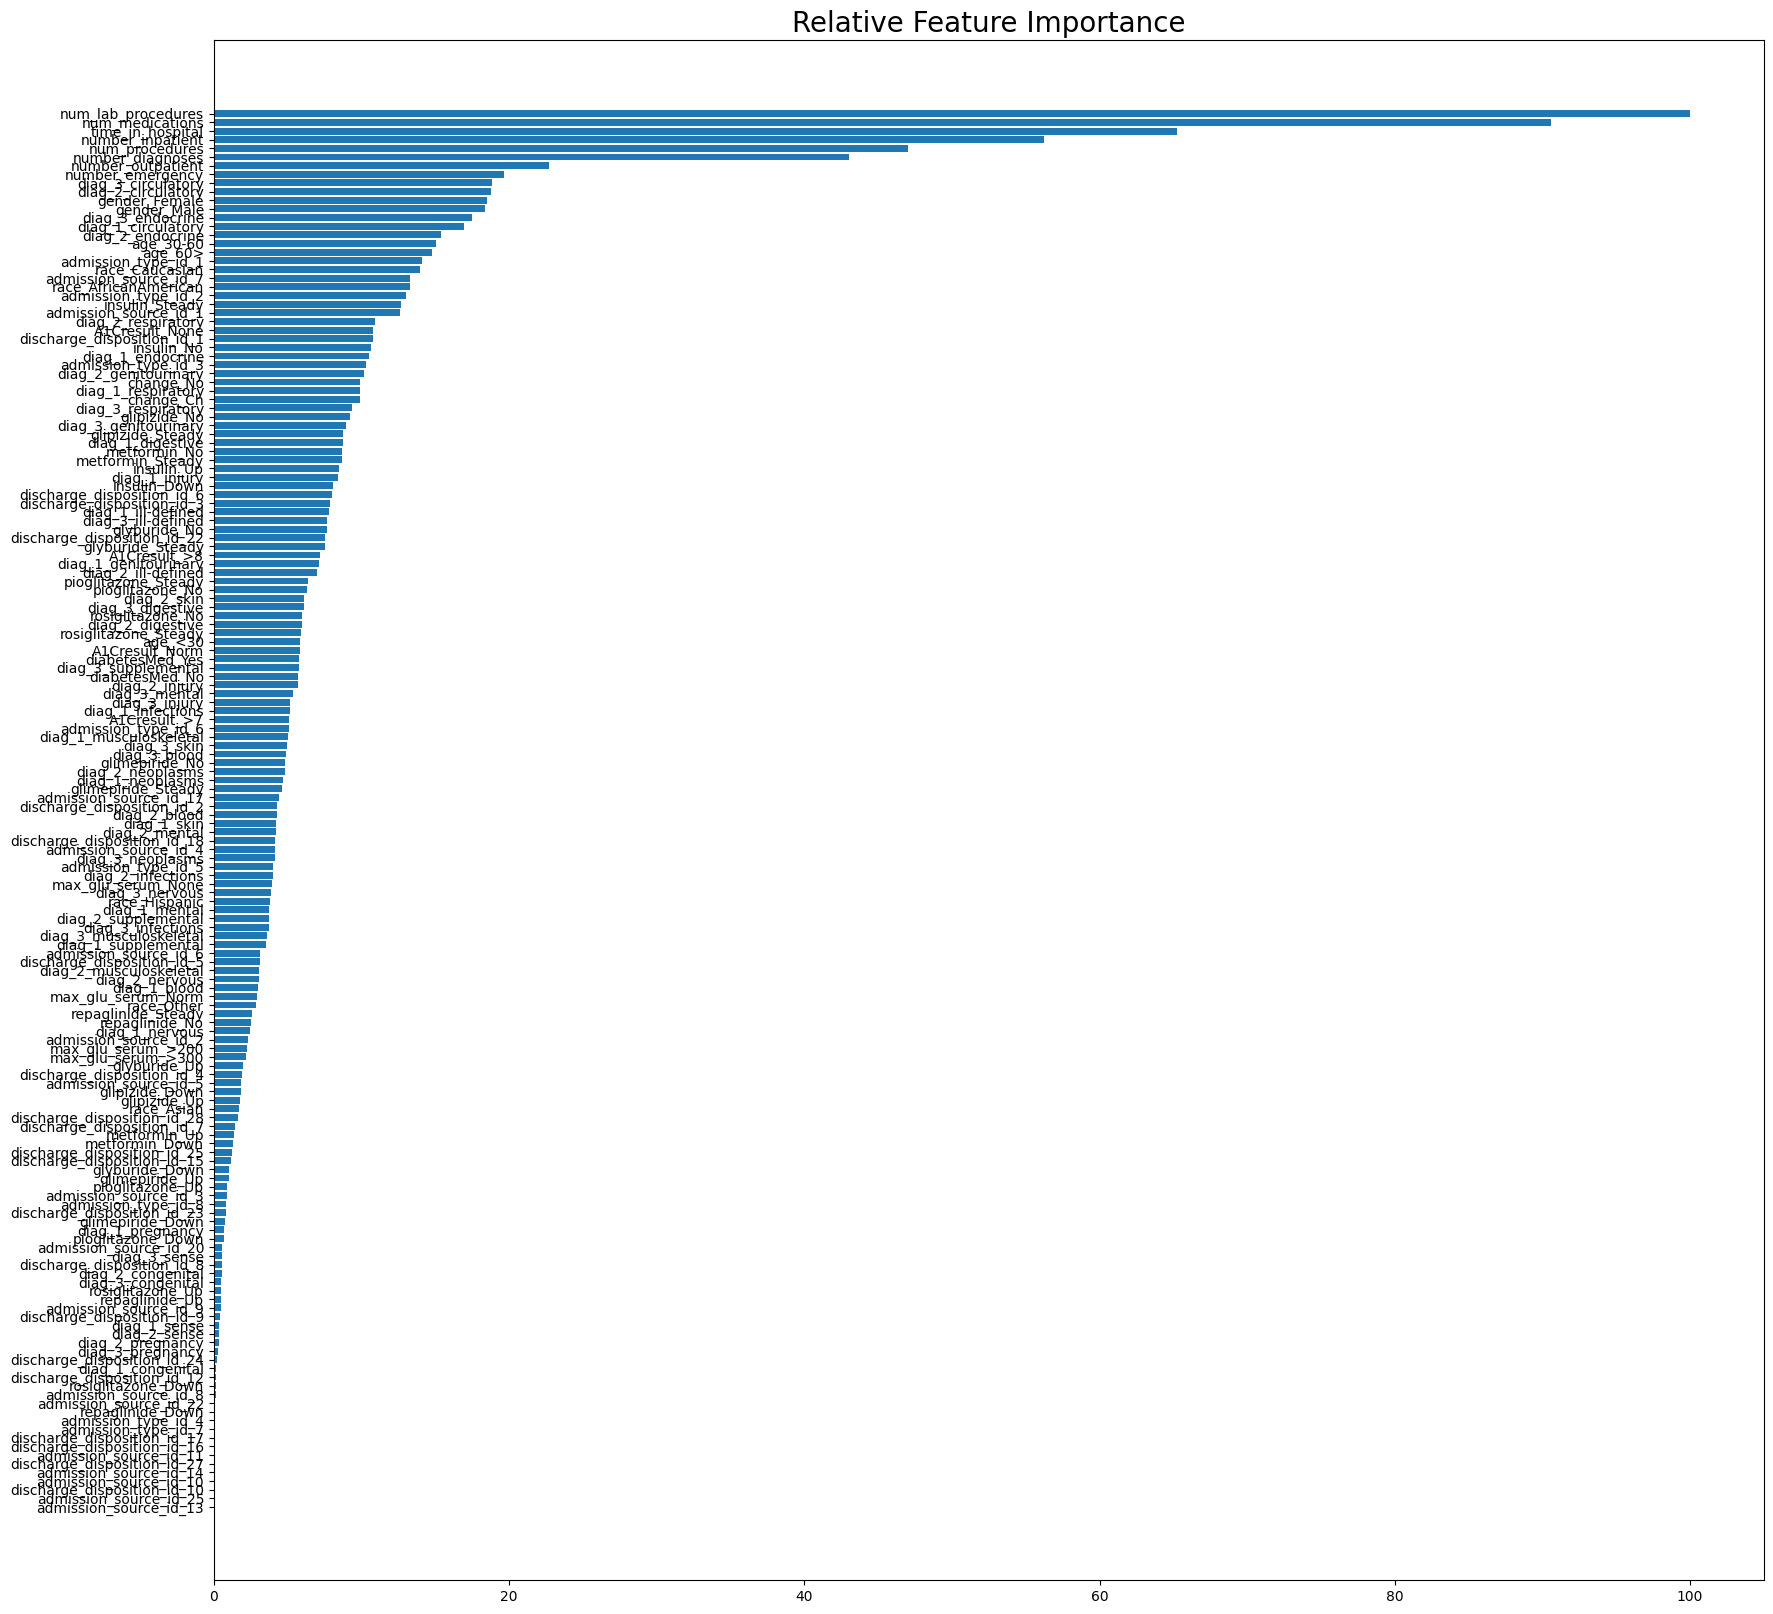

In [76]:
# create X (features) and y (response)
X = diabetes2.drop(['readmitted'], axis=1)
y = diabetes2['readmitted']
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.25)
# fit Random Forest model to the cross-validation data
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()
forest.fit(X_cv, y_cv)
importances = forest.feature_importances_
# make importance relative to the max importance
feature_importance = 100.0 * (importances / importances.max())
sorted_idx = np.argsort(feature_importance)
feature_names = list(X_cv.columns.values)
feature_names_sort = [feature_names[indice] for indice in sorted_idx]
pos = np.arange(sorted_idx.shape[0]) + .5
print('Top 10 features are: ')
for feature in feature_names_sort[::-1][:10]:
    print(feature)
# plot the result
plt.figure(figsize=(20, 20))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names_sort)
plt.title('Relative Feature Importance', fontsize=20)
plt.show()